In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/DIQ_data

Mounted at /gdrive
/gdrive/My Drive/DIQ_data


Loading Dirty Dataset...
Calculating completion time...
Preprocessing data...
Handling outliers in Completion_Time...
Performing feature engineering...
Optimizing LightGBM parameters...
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1215
[LightGBM] [Info] Number of data points in the train set: 70256, number of used features: 23
[LightGBM] [Info] Start training from score 142.564991
Best parameters found: {'num_leaves': 100, 'n_estimators': 500, 'min_data_in_leaf': 20, 'max_depth': -1, 'learning_rate': 0.1}
Evaluating the model on Dirty Datas

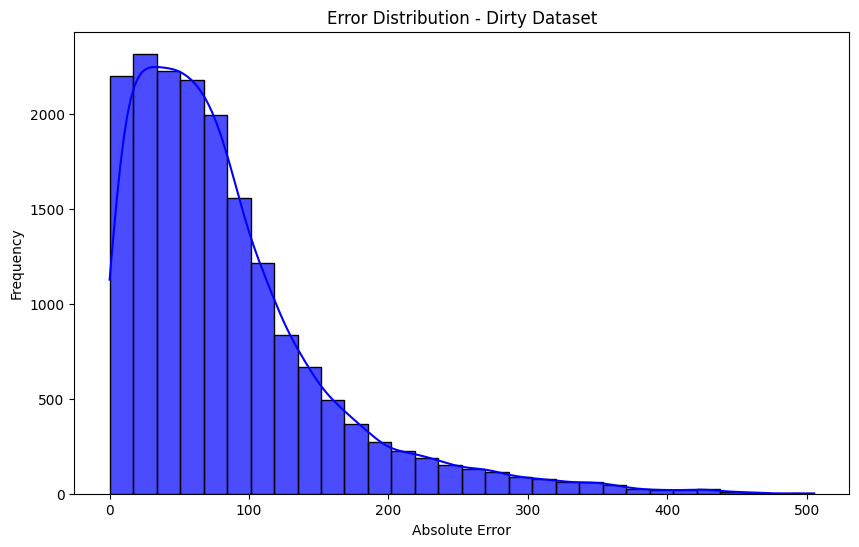

Top 5 Worst Predictions for Dirty Dataset:
         True  Predicted       Error
84140  537.0  31.614507  505.385493
97459  559.0  65.514733  493.485267
69734  561.0  76.896881  484.103119
38634  565.0  99.240754  465.759246
36890  518.0  53.328929  464.671071
Loading Clean Dataset...
Calculating completion time...
Preprocessing data...
Handling outliers in Completion_Time...
Performing feature engineering...
Optimizing LightGBM parameters...
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1215
[LightGBM] [Info] Number of data points in the tra

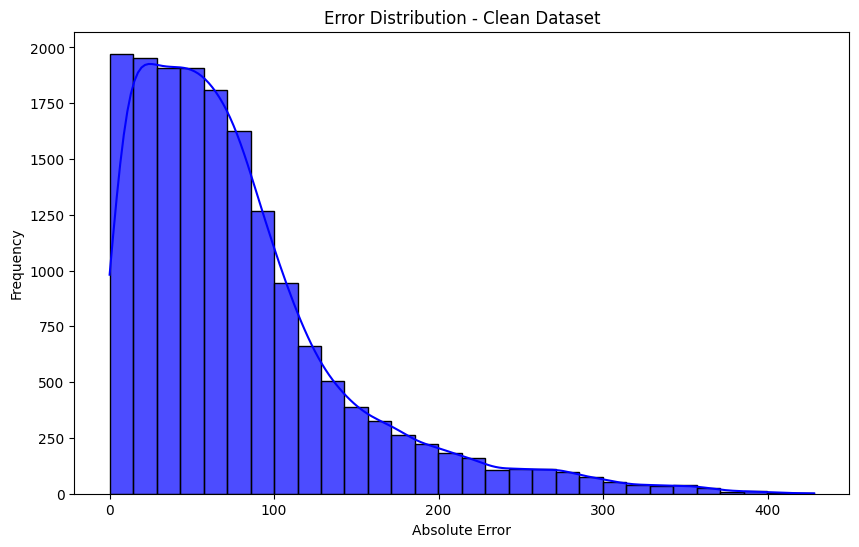

Top 5 Worst Predictions for Clean Dataset:
            True  Predicted       Error
13269.0   500.0  71.627029  428.372971
62477.0   469.0  44.392157  424.607843
46956.0   487.0  70.868418  416.131582
174656.0  465.0  55.547059  409.452941
131771.0  447.0  38.963524  408.036476


In [5]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import RandomizedSearchCV

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Step 1: Calculate Completion Time
def calculate_completion_time(df):
    print("Calculating completion time...")
    df["Permit_Date"] = pd.to_datetime(df["Permit Creation Date"], errors="coerce")
    df["Completion_Date"] = pd.to_datetime(df["Completed Date"], errors="coerce")
    df["Completion_Time"] = (df["Completion_Date"] - df["Permit_Date"]).dt.days
    df = df[df["Completion_Time"] >= 0]  # Filter invalid or negative durations
    return df

# Step 2: Outlier Handling
def handle_outliers(df, column, method="zscore", z_thresh=3, iqr_multiplier=1.5):
    print(f"Handling outliers in {column}...")
    if method == "zscore":
        df["z_score"] = zscore(df[column])
        df = df[df["z_score"].abs() <= z_thresh]
        df.drop(columns=["z_score"], inplace=True)
    elif method == "iqr":
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (iqr_multiplier * iqr)
        upper_bound = q3 + (iqr_multiplier * iqr)
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Step 3: Feature Engineering
def feature_engineering(df):
    print("Performing feature engineering...")
    df["Cost Difference"] = df["Revised Cost"] - df["Estimated Cost"]
    df["Cost Ratio"] = df["Revised Cost"] / df["Estimated Cost"].replace(0, 1)  # Prevent division by zero
    df["Year"] = df["Permit_Date"].dt.year
    df["Month"] = df["Permit_Date"].dt.month
    df["Day"] = df["Permit_Date"].dt.day
    df["Weekday"] = df["Permit_Date"].dt.weekday
    df["Is_Weekend"] = df["Weekday"].apply(lambda x: 1 if x >= 5 else 0)
    return df

# Step 4: Preprocessing Function
def preprocess_data(df):
    print("Preprocessing data...")
    df = handle_outliers(df, "Completion_Time", method="iqr")  # Improved outlier handling with IQR
    df = df.dropna(subset=["Completion_Time"])  # Remove rows with missing target
    df = feature_engineering(df)
    return df

# Step 5: Hyperparameter Optimization for LightGBM
def optimize_lightgbm(X_train, y_train):
    print("Optimizing LightGBM parameters...")
    param_dist = {
        "num_leaves": [31, 50, 100],
        "learning_rate": [0.01, 0.05, 0.1],
        "n_estimators": [100, 200, 500],
        "max_depth": [-1, 5, 10],
        "min_data_in_leaf": [20, 50, 100],
    }
    lgb_model = lgb.LGBMRegressor(random_state=42)
    grid_search = RandomizedSearchCV(
        lgb_model, param_dist, cv=3, scoring="neg_mean_absolute_error", n_iter=20, random_state=42, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print("Best parameters found:", grid_search.best_params_)
    return grid_search.best_estimator_

# Step 6: Regression Pipeline with Relevant Features
def regression_pipeline(df, dataset_name):
    # Selected features and target
    features = [
        "Estimated Cost", "Revised Cost", "Permit Type", "Number of Existing Stories",
        "Number of Proposed Stories", "Supervisor District", "Cost Difference",
        "Cost Ratio", "Year", "Month", "Day", "Weekday", "Is_Weekend"
    ]
    target = "Completion_Time"

    # Filter relevant columns
    df = df[features + [target]].dropna()

    # Split data
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing pipelines
    numerical_features = [
        "Estimated Cost", "Revised Cost", "Number of Existing Stories",
        "Number of Proposed Stories", "Cost Difference", "Cost Ratio", "Year", "Month", "Day", "Weekday"
    ]
    categorical_features = ["Permit Type", "Supervisor District"]

    numerical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    # Preprocess the data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    # Optimize and train the LightGBM model
    lgb_model = optimize_lightgbm(X_train, y_train)

    # Evaluate the model
    print(f"Evaluating the model on {dataset_name}...")
    y_pred = lgb_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{dataset_name} Results - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

    # Baseline comparison
    print("Baseline (Mean Predictor) Performance:")
    mean_baseline = np.full_like(y_test, np.mean(y_train))
    baseline_mae = mean_absolute_error(y_test, mean_baseline)
    baseline_mse = mean_squared_error(y_test, mean_baseline)
    print(f"Baseline MAE: {baseline_mae:.2f}, MSE: {baseline_mse:.2f}")

    # Error distribution analysis
    errors = np.abs(y_test - y_pred)
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=30, color="blue", alpha=0.7)
    plt.title(f"Error Distribution - {dataset_name}")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.show()

    # Top 5 worst predictions
    error_df = pd.DataFrame({"True": y_test, "Predicted": y_pred, "Error": errors})
    error_df = error_df.sort_values(by="Error", ascending=False).head(5)
    print(f"Top 5 Worst Predictions for {dataset_name}:\n", error_df)

    return lgb_model

# Step 7: Run Pipeline for Both Datasets
def run_pipeline(dirty_file_path, clean_file_path):
    # Load dirty dataset
    print("Loading Dirty Dataset...")
    dirty_df = pd.read_csv(dirty_file_path)

    # Calculate completion time for dirty dataset
    dirty_df = calculate_completion_time(dirty_df)
    dirty_df = preprocess_data(dirty_df)

    # Run regression pipeline for dirty dataset
    dirty_model = regression_pipeline(dirty_df, "Dirty Dataset")

    # Load clean dataset
    print("Loading Clean Dataset...")
    clean_df = pd.read_parquet(clean_file_path)

    # Calculate completion time for clean dataset
    clean_df = calculate_completion_time(clean_df)
    clean_df = preprocess_data(clean_df)

    # Run regression pipeline for clean dataset
    clean_model = regression_pipeline(clean_df, "Clean Dataset")

    return dirty_model, clean_model

# Step 8: Main Execution
if __name__ == "__main__":
    dirty_file_path = "/gdrive/MyDrive/DIQ_data/building_permits.csv"  # Update with actual path to dirty dataset
    clean_file_path = "/gdrive/MyDrive/DIQ_data/dataset.parquet"  # Update with actual path to clean dataset

    dirty_model, clean_model = run_pipeline(dirty_file_path, clean_file_path)